# Date Fruit Dataset - Analysis and Model Training
This dataset comes from a paper (reference below) which extracted features from 898 images of 7 different Date species in an effort ot classify them using Logistic Regression and Artificial Neural Networks, which yielded classification accuracies of 91.0% and 92.2%, respectively. Stacking the models yielded a slight increase in accuracy (92.8%).

In `1-analysis.ipynb`, we examined the data to select, transform, and scale features for model training. Using these data, we will now fit machine learning algorithms and measure their performance.

KOKLU, M., KURSUN, R., TASPINAR, Y. S., and CINAR, I. (2021). Classification of Date Fruits into Genetic Varieties Using Image Analysis. Mathematical Problems in Engineering, Vol.2021, Article ID: 4793293, DOI:10.1155/2021/4793293
https://www.hindawi.com/journals/mpe/2021/4793293/
DATASET: https://www.muratkoklu.com/datasets/
https://www.kaggle.com/mkoklu42

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import RepeatedKFold, GridSearchCV

df1 = pd.read_excel("Date_Fruit_Datasets/raw_dataset.xlsx")
df2 = pd.read_excel("Date_Fruit_Datasets/reduced_features_dataset.xlsx")
df3 = pd.read_excel("Date_Fruit_Datasets/scaled_reduced_dataset.xlsx")
df1.rename(columns={'Class':'Species'}, inplace=True)
df1 = df1[df1["MINOR_AXIS"] > 50].reset_index().drop(["index"], axis=1)
df2 = df2[df2["MINOR_AXIS"] > 50].reset_index().drop(["index"], axis=1)
labels = LabelEncoder().fit_transform(df1["Species"]).reshape(-1, 1)
onehot_y = OneHotEncoder().fit_transform(labels).toarray()

Model 1 (gold)
Accuracy	7.5±3.0%
F1-score	17.2±5.9%
Model 2 (blue)
Accuracy	7.0±3.5%
F1-score	16.7±5.5%
Model 3 (purple)
Accuracy	7.5±3.4%
F1-score	17.2±5.2%


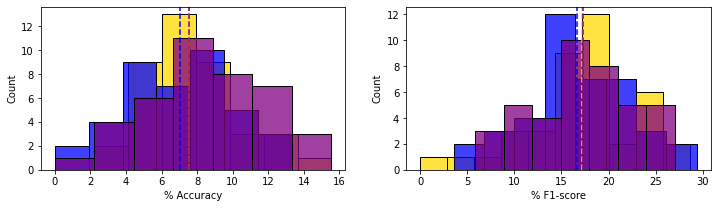

In [18]:
rkf = RepeatedKFold(n_splits=20, n_repeats=2, random_state=42)
dumb = DummyClassifier(strategy="stratified")

def model_performance(dfs, y, model, colors=("gold", "blue", "purple")):
    """
    Loop over a list of dataframes (dfs), apply k-fold cross-validation,
    train on these splits, and report prediction accuracy on the test
    splits. Plot histograms of each models accuracy with a vertical
    line indicating the mean.
    """
    results = []
    plt.figure(figsize=(12, 3))
    for i, df in enumerate(dfs):
        print(f"Model {i+1} ({colors[i]})")
        acc = []
        f1s = []
        X = np.array(df.iloc[:, :-1])
        for train_index, test_index in rkf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            y_pred = model.predict(X_test)
            f1 = f1_score(y_test, y_pred, average="weighted")
            acc.append(score)
            f1s.append(f1)
        acc = np.array(acc) * 100
        f1 = np.array(f1s) * 100
        for idx,(metric, lbl) in enumerate(zip((acc, f1), ("Accuracy", "F1-score")), 1):
            plt.subplot(1, 2, idx)
            sns.histplot(metric, color=colors[i])
            mean = np.mean(metric)
            std = np.std(metric)
            print(f"{lbl}\t{mean:.1f}±{std:.1f}%")
            plt.axvline(mean, c=colors[i], ls="--")
            plt.xlabel(f"% {lbl}")
                
model_performance((df1, df2, df3), onehot_y, dumb)

A dummy classifier is useful for establishing baseline performance of a simplistic classifier. For this multiclass classification problem, the classifier makes predictions based on the class distributions in the training data.
* <font color=gold>Gold</font> indicates all the features from the raw dataset
* <font color=blue>Blue</font> indicates our chosen subset of features
* <font color=purple>Purple</font> indicates the subset after transformations and scaling have been applied

The baseline model should perform equally well across all datasets since they contain the same labels and the feature data isn't used for predictions. This method yields a <strong>baseline prediction accuracy of 6-7%</strong>, which should be beaten by adequately-trained models.

Since accuracy can be affected by unbalanced data, we also note the F1 score:

$ F_{1} = \frac{TP}{TP + \frac{1}{2}(FP + FN) } $

where TP = True Positives, FP = False Positives, and FN = False Negatives. This metric will help us better understand how our model is performing.

Model 1 (gold)
Accuracy	47.4±9.2%
F1-score	41.4±9.4%
Model 2 (blue)
Accuracy	18.5±7.1%
F1-score	6.4±4.3%
Model 3 (purple)
Accuracy	86.8±4.6%
F1-score	86.6±4.8%


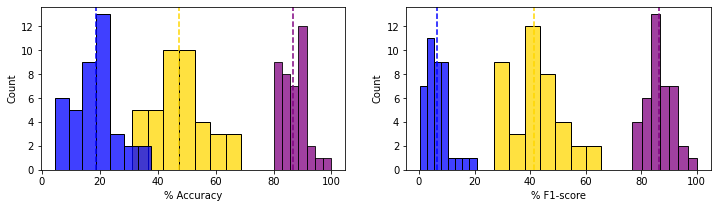

In [19]:
# One-vs-rest setting produces one LR model for each class in our multiclass classification problem
model = LogisticRegression(class_weight="balanced", multi_class="ovr", random_state=42)
model_performance((df1, df2, df3), df1.iloc[:, -1], model)

Logistic regression beats the baseline model in all cases. By subsetting our features without checking feature variance, we may have lost important information. This turns out to be true, since the <font color=gold>accuracy obtained with all features</font> is far better than the <font color=blue>model which saw a subset of those features</font>.

The jump in <font color=purple>accuracy when we transform and scale these data</font> highlights the power and importance of these processing steps when including them in a linear model such as Logistic Regression.

<strong>Note:</strong> The clear separation in the histograms indicates how the models differ in their predictive power. 

Model 1 (gold)
Accuracy	89.4±5.3%
F1-score	89.3±5.3%
Model 2 (blue)
Accuracy	87.8±5.1%
F1-score	87.7±5.3%
Model 3 (purple)
Accuracy	87.4±5.0%
F1-score	87.3±5.3%


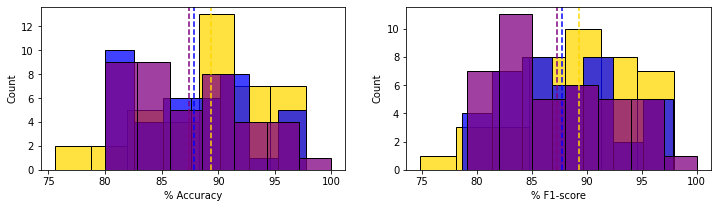

In [20]:
model = RandomForestClassifier(class_weight="balanced", random_state=42)
model_performance((df1, df2, df3), df1.iloc[:, -1], model)

As a non-linear technique, Random Forest models generally learn to fit the data quite well, as evidenced by the comparable accuracy for each dataset. Using all the raw data without transformation (blue) appears to be the best model, but the overlap in histograms and standard deviation between the models indicates that any of these models will suffice.

While Random Forests are a powerful ensemble technique, they are prone to overfitting and are less straightforward to interpret than a Logistic Regression model. A probabilistic model such as the Gaussian Naive Bayes classifier is also simple to interpret, trains fast, and performs well once the features are independent and normally distributed. These assumptions hold true for our transformed and scaled dataset, so we can expect good results with this method.

Model 1 (gold)
Accuracy	58.3±7.9%
F1-score	55.6±8.8%
Model 2 (blue)
Accuracy	51.9±8.2%
F1-score	44.1±8.9%
Model 3 (purple)
Accuracy	88.0±5.1%
F1-score	87.7±5.4%


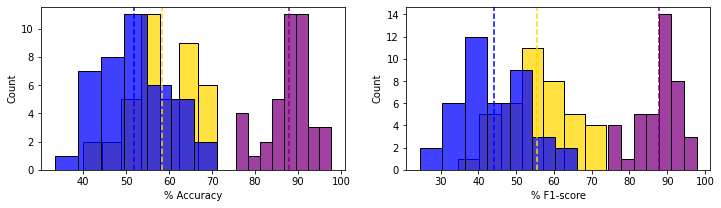

In [21]:
model = GaussianNB()
model_performance((df1, df2, df3), df1.iloc[:, -1], model)

Naive Bayes performs as well as the Random Forest and Logistic Regression models on the transformed and scaled data. It also seems to work better on the <font color=blue>raw data</font> than the Logistic Regression model, despite the lack of feature selection.

Let's quickly take a look at the certainty of our predictions before moving on to the last section. By selecting one sample from each `Species`, we can examine the probabilities generated by our Naive Bayes Model. The great thing is that each time we re-run the cell below, the sample chosen by the builtin `Pandas` function will change so we can refresh the cell again and again to see how the model deals with different data!

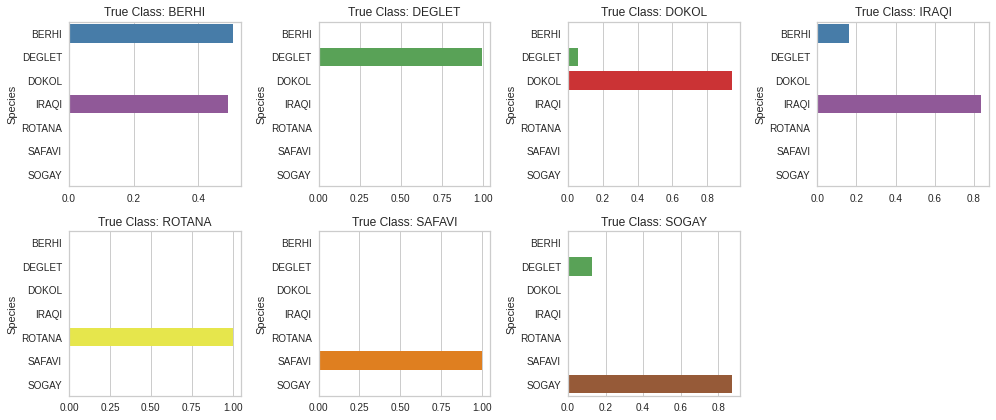

In [32]:
sample = df3.groupby("Species").apply(lambda x: x.sample(n=1))
sample = sample.drop(columns=["Species"]).reset_index() # make index equal to encoding
sample.drop(columns=["level_1"], inplace=True)

plt.figure(figsize=(14, 6))
for idx, row in sample.iterrows():
    true = row["Species"]
    data = np.array(row[1:]).reshape(1, -1)
    probs = model.predict_proba(data).ravel()
    plt.subplot(2, 4, idx+1)
    sns.barplot(y=sample["Species"], x=probs)
    plt.title(f"True Class: {true}")
plt.tight_layout()

## Visualization of class predictions
The high classification accuracy and F1 scores indicate that our models are functioning well and can distinguish between the 7 species of Date in the dataset. `Yellowbrick` is a Python library that aims to improve visualization and interpretation of machine learning models. It does so by providing a number of useful visualizations that many Data Scientists would code from scratch.

The `PCA` visualizer takes in our data and transforms it using Principal Component Analysis to display it on a 2D* scatter plot and color codes each point by the class. This allows us to visually check for separation in the classes. Since we already know that our models are working well, this plot serves to confirm what we already know.

\* if you require a 3D scatter plot, you can specify the argument `projection=3`

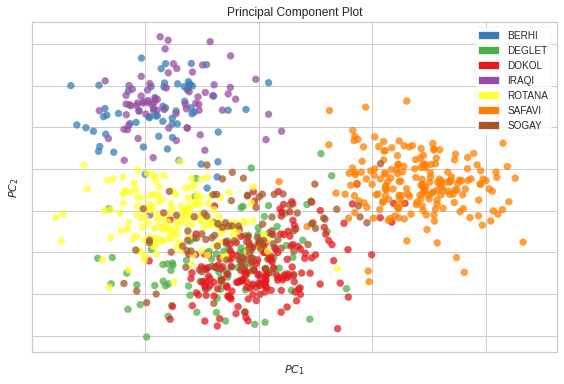

In [15]:
import shap
from yellowbrick.features import PCA
from yellowbrick.classifier import ClassPredictionError
from sklearn.model_selection import train_test_split
from yellowbrick.style import set_palette
set_palette('set1') # remove this line to use default colors. Default only has 6 colors > limits visualization of 7 classes

classes=df3["Species"].unique()

visualizer = PCA(scale=True, project_features=True, classes=classes, projection=2)
visualizer.fit_transform(df3.iloc[:, :-1], labels.ravel())
_ = visualizer.show()

Yellowbrick also provides a barplot representation of the confusion matrix, which is especially useful for our data since a 7x7 confusion matrix would require some concentration to interpret. The plot below allows us to quickly see which classes are being misclassified and how often.

Accuracy on test data: 86.7%


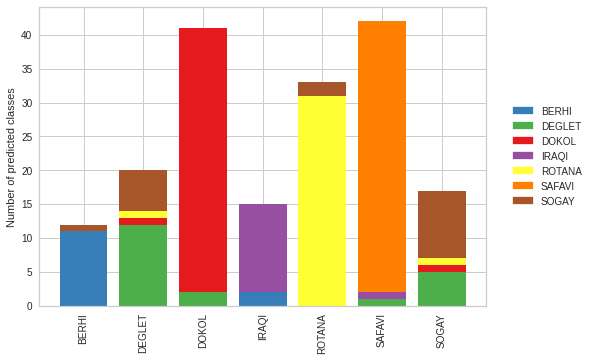

In [24]:
X = df3.iloc[:, :-1]
y = df3["Species"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y,
                                                    random_state=42)
model = GaussianNB()
model.fit(X_train, y_train)
visualizer = ClassPredictionError(
    LogisticRegression(class_weight="balanced", multi_class="ovr", random_state=42),
    classes=classes)
visualizer.fit(X_train, y_train)
score = visualizer.score(X_test, y_test)
plt.ylabel("Number of predicted classes")
print(f"Accuracy on test data: {score*100:.1f}%")

Comparing the PCA plot with the barplot above, we can see how the 3 most prevalent classes (Dokol, Rotana, Safavi) are correctly classified most of the time, while the less represented classes are not so well-classified.

Notice also that this plot is a more compact and nicer representation of the probabilities observed in the last figure of the previous section. It also took fewer lines of code and is always available in the `shap` package. Handy!